In [1]:
# 📦 Import core libraries
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

# 📂 Load environment variables (DB credentials)
load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD") or ""
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# Create engine for PostgreSQL connection
DATABASE_URL = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(DATABASE_URL)

print("✅ Environment loaded & DB connection ready")


Matplotlib is building the font cache; this may take a moment.


✅ Environment loaded & DB connection ready


In [2]:
# 📥 Query only necessary columns from raw_clicks
query = """
SELECT ad_id, ip_address
FROM raw_clicks
LIMIT 5000; -- limit for faster prototype
"""

df_clicks = pd.read_sql(query, engine)
print(f"Loaded {len(df_clicks):,} click records")
df_clicks.head()


Loaded 5,000 click records


,ad_id,ip_address
0,AD005,87540
1,AD004,105560
2,AD003,101424
3,AD001,94584
4,AD009,68413


In [3]:
# 🎯 The bipartite graph will have:
#   - IP addresses as one set of nodes
#   - Ads (ad_id) as the other set

B = nx.Graph()

# Add nodes with bipartite attribute
ips = df_clicks["ip_address"].unique()
ads = df_clicks["ad_id"].unique()

B.add_nodes_from(ips, bipartite="ip")
B.add_nodes_from(ads, bipartite="ad")

# Add edges from clicks
B.add_edges_from(df_clicks.itertuples(index=False, name=None))

print(f"Graph has {B.number_of_nodes()} nodes and {B.number_of_edges()} edges")


Graph has 4067 nodes and 4762 edges


In [ ]:
# 🕵️ Find suspicious clusters using greedy modularity
from networkx.algorithms import community

communities = community.greedy_modularity_communities(B)

print(f"Detected {len(communities)} communities")

# Convert communities to DataFrame for inspection
community_data = []
for idx, comm in enumerate(communities):
    for node in comm:
        community_data.append({"node": node, "community": idx})

df_communities = pd.DataFrame(community_data)
df_communities.head()


In [4]:
# 🚨 Simple heuristic: IPs connected to many different ads are suspicious

# Degree centrality (number of connections)
degree_centrality = dict(B.degree())

# Filter only IP nodes
ip_scores = {ip: degree_centrality[ip] for ip in ips}

# Sort and display top suspicious IPs
suspicious_ips = sorted(ip_scores.items(), key=lambda x: x[1], reverse=True)[:10]
pd.DataFrame(suspicious_ips, columns=["ip_address", "connections"])


,ip_address,connections
0,999.999.999.999,10
1,5348,10
2,73487,10
3,5314,9
4,73516,9
5,17149,9
6,95766,8
7,123994,7
8,105475,7
9,53454,7


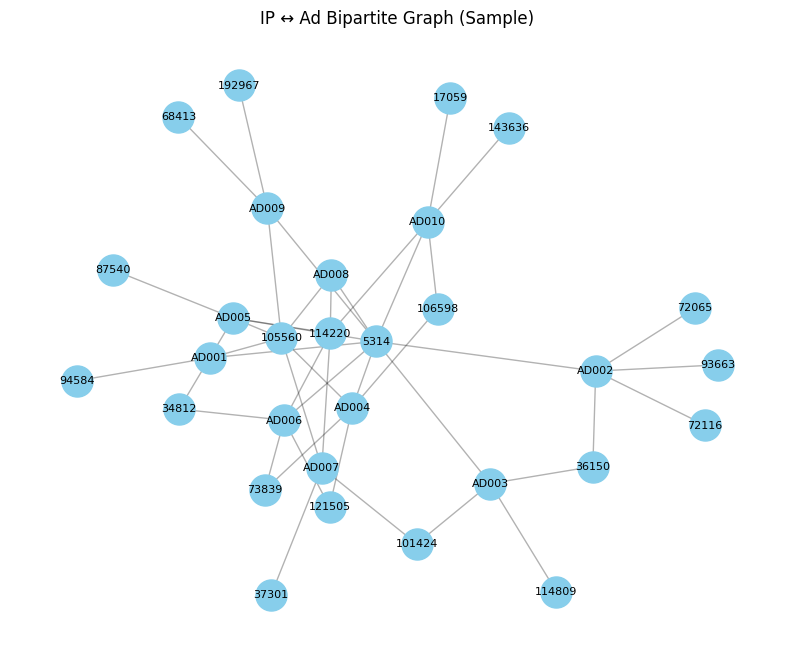

In [5]:
# 🎨 Draw a small subgraph for visualization
sub_nodes = list(ips[:20]) + list(ads[:10])
subgraph = B.subgraph(sub_nodes)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)

nx.draw_networkx_nodes(subgraph, pos, node_color="skyblue", node_size=500)
nx.draw_networkx_edges(subgraph, pos, alpha=0.3)
nx.draw_networkx_labels(subgraph, pos, font_size=8)

plt.title("IP ↔ Ad Bipartite Graph (Sample)")
plt.axis("off")
plt.show()


# 📝 Ideas to expand:
# - Weight edges by number of clicks between IP & Ad
# - Use Louvain method for community detection
# - Merge with ad_performance to cross-check fraud patterns
# - Export suspicious IPs to a CSV for review